# Preliminaries

In [1]:
# For data frames:
import pandas as pd

# For arrays:
import numpy as np

# For optimization:
import scipy

In [2]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
# For plotting:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# For OLS regression:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


---

# Supervised learning using scikit-learn

Supervised learning is a type of machine learning (ML) that involves predicting a ground truth. And we must have some examples in order to "supervise" the learning algorithm.

We'll demonstrate this by predicting whether borrowers will default on a loan. We know the ground truth: whether they have or not. And we will supervise the algorithm as it learns how to predict this fact.

This task is a **classification** task: the loan can be in a discrete state of defaulted or not defaulted. If we are trying to predict which state/**class** a loan will end up in, it's a classification problem.

## Load loans dataset

In [5]:
loans_df = pd.read_csv('Loan_Default.csv')

In [6]:
len(loans_df)

255347

In [7]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [8]:
loans_df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


<Axes: >

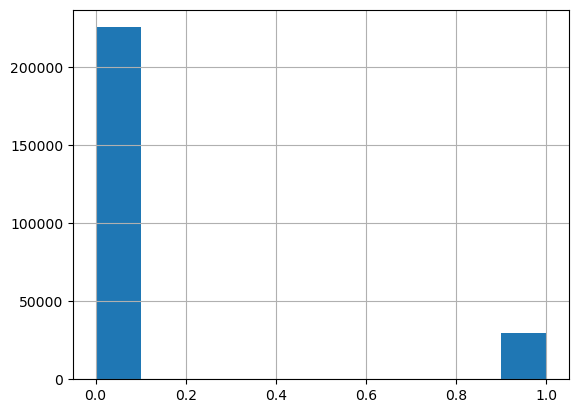

In [9]:
loans_df['Default'].hist()

## ML-specific cleaning & processing

In [10]:
# A LoanID column will not generalize, and should be excluded
loans_df.drop(columns=['LoanID'], inplace=True)
loans_df.columns.values

array(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
       'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype=object)

In [11]:
# These 3 columns are Yes/No...
print(loans_df['HasMortgage'].unique())
print(loans_df['HasDependents'].unique())
print(loans_df['HasCoSigner'].unique())


['Yes' 'No']
['Yes' 'No']
['Yes' 'No']


In [12]:
# ... so convert them to boolean True/False. (or 1/0 would also work)
loans_df['HasMortgage'] = (loans_df['HasMortgage'] == 'Yes')
loans_df['HasDependents'] = (loans_df['HasDependents'] == 'Yes')
loans_df['HasCoSigner'] = (loans_df['HasCoSigner'] == 'Yes')

In [13]:
loans_df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,True,True,Other,True,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,False,False,Other,True,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,True,True,Auto,False,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,False,False,Business,False,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,False,True,Auto,False,0


### One-hot encoding

There are 4 non-binary text columns remaining that need to be converted to a numerical format somehow.

One-hot encoding is a standard way of doing so.

In [14]:
print(loans_df['Education'].unique())
print(loans_df['EmploymentType'].unique())
print(loans_df['MaritalStatus'].unique())
print(loans_df['LoanPurpose'].unique())

["Bachelor's" "Master's" 'High School' 'PhD']
['Full-time' 'Unemployed' 'Self-employed' 'Part-time']
['Divorced' 'Married' 'Single']
['Other' 'Auto' 'Business' 'Home' 'Education']


In [15]:
# Demonstration of one-hot encoding on the Education column
temp_df = pd.get_dummies(data = loans_df, columns=['Education'])

print(temp_df.columns.values)

temp_df.head()


['Age' 'Income' 'LoanAmount' 'CreditScore' 'MonthsEmployed'
 'NumCreditLines' 'InterestRate' 'LoanTerm' 'DTIRatio' 'EmploymentType'
 'MaritalStatus' 'HasMortgage' 'HasDependents' 'LoanPurpose' 'HasCoSigner'
 'Default' "Education_Bachelor's" 'Education_High School'
 "Education_Master's" 'Education_PhD']


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_Bachelor's,Education_High School,Education_Master's,Education_PhD
0,56,85994,50587,520,80,4,15.23,36,0.44,Full-time,Divorced,True,True,Other,True,0,True,False,False,False
1,69,50432,124440,458,15,1,4.81,60,0.68,Full-time,Married,False,False,Other,True,0,False,False,True,False
2,46,84208,129188,451,26,3,21.17,24,0.31,Unemployed,Divorced,True,True,Auto,False,1,False,False,True,False
3,32,31713,44799,743,0,3,7.07,24,0.23,Full-time,Married,False,False,Business,False,0,False,True,False,False
4,60,20437,9139,633,8,4,6.51,48,0.73,Unemployed,Divorced,False,True,Auto,False,0,True,False,False,False


In [16]:
# We'll run it on all 4 columns:
loans_df = pd.get_dummies(data = loans_df, columns=['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose'])

In [17]:
# Everything is now a bool, int or float
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 29 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           255347 non-null  int64  
 1   Income                        255347 non-null  int64  
 2   LoanAmount                    255347 non-null  int64  
 3   CreditScore                   255347 non-null  int64  
 4   MonthsEmployed                255347 non-null  int64  
 5   NumCreditLines                255347 non-null  int64  
 6   InterestRate                  255347 non-null  float64
 7   LoanTerm                      255347 non-null  int64  
 8   DTIRatio                      255347 non-null  float64
 9   HasMortgage                   255347 non-null  bool   
 10  HasDependents                 255347 non-null  bool   
 11  HasCoSigner                   255347 non-null  bool   
 12  Default                       255347 non-nul

### Splitting columns into Y,X

In [18]:
# Split data into the labels Y and predictors X

# What we want to predict
Y = loans_df['Default']

# Everything else
X = loans_df.drop(columns=['Default'], axis=1)


In [19]:
print(Y.shape)
print(X.shape)

(255347,)
(255347, 28)


### Splitting rows into training & test samples

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and test/holdout/out-of-sample sets
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state=42)

In [22]:
print(train_Y.shape)
print(train_X.shape)

(191510,)
(191510, 28)


In [23]:
print(test_Y.shape)
print(test_X.shape)

(63837,)
(63837, 28)


## Training and evaluating a RandomForestClassifier

### Training on the training data

In [34]:
# Create a classifier using a RandomForest algorithm...
model = RandomForestClassifier(random_state=42, n_estimators=10)

# ... and fit it to our training data
model.fit(train_X, train_Y)

RandomForestClassifier(n_estimators=10, random_state=42)

### Evaluating on the same training data

In [35]:
# Use this trained model to generate predictions for the training data
train_Y_pred = model.predict(train_X)
train_Y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [36]:
# How well do those predictions perform?
confusion = confusion_matrix(y_true = train_Y, y_pred = train_Y_pred)
confusion

array([[169270,     14],
       [  3191,  19035]])

In [37]:
true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

print('Count of true negatives (predicted 0, true 0)  =  ' + str(true_negatives))
print('Count of false negatives (predicted 0, true 1)  =  ' + str(false_negatives))
print('Count of false positives (predicted 1, true 0)  =  ' + str(false_positives))
print('Count of true positives (predicted 1, true 1)  =  ' + str(true_positives))

Count of true negatives (predicted 0, true 0)  =  169270
Count of false negatives (predicted 0, true 1)  =  3191
Count of false positives (predicted 1, true 0)  =  14
Count of true positives (predicted 1, true 1)  =  19035


In [38]:
# Simpler measure of classification accuracy:
(train_Y == train_Y_pred).mean()

0.9832645814839956

### Evaluating out-of-sample on the test/holdout data

In [39]:
# Use this trained model to generate predictions for the test data
test_Y_pred = model.predict(test_X)
test_Y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
# How well do those predictions perform?
confusion = confusion_matrix(y_true = test_Y, y_pred = test_Y_pred)
confusion

array([[55924,   486],
       [ 7051,   376]])

In [41]:
true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

print('Count of true negatives (predicted 0, true 0)  =  ' + str(true_negatives))
print('Count of false negatives (predicted 0, true 1)  =  ' + str(false_negatives))
print('Count of false positives (predicted 1, true 0)  =  ' + str(false_positives))
print('Count of true positives (predicted 1, true 1)  =  ' + str(true_positives))

Count of true negatives (predicted 0, true 0)  =  55924
Count of false negatives (predicted 0, true 1)  =  7051
Count of false positives (predicted 1, true 0)  =  486
Count of true positives (predicted 1, true 1)  =  376


In [42]:
# Simpler measure of classification accuracy:
print('Prediction accuracy rate = ', str((test_Y == test_Y_pred).mean()))

Prediction accuracy rate =  0.8819336748280777


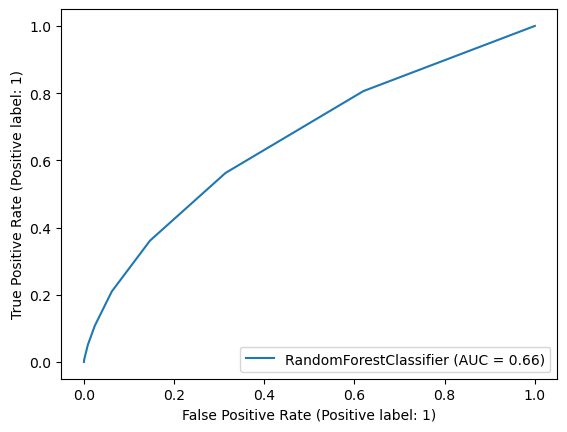

In [43]:
RocCurveDisplay.from_estimator(model, test_X, test_Y)

### Let's try with a different set of hyperparameters

Prediction accuracy rate =  0.8854582765480834


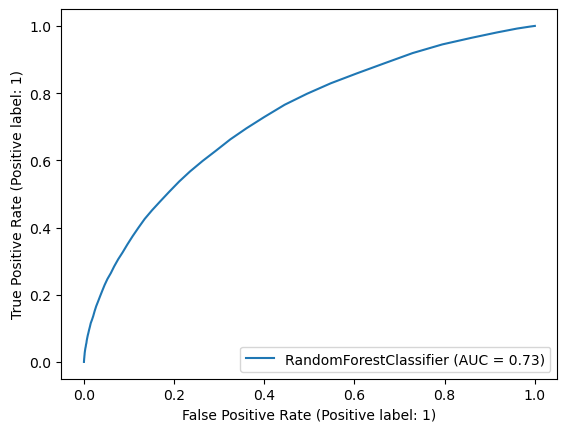

In [44]:
# Create & fit
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(train_X, train_Y)

# Evaluate on the test data
test_Y_pred = model.predict(test_X)
print('Prediction accuracy rate = ', str((test_Y == test_Y_pred).mean()))

RocCurveDisplay.from_estimator(model, test_X, test_Y)

Using `n_estimators=100` produces better out-of-sample results than using `n_estimators=10`.

There are other hyperparameters that could be set, too. See the full list at 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


How about systematically picking the value of these hyperparameters? This is called "hyperparameter tuning", and we can do this with cross-validation. 

It can be computationally expensive, so I will leave cross-validation for a homework exercise later.


### Explaining the most important features

Determining the most important "features" (i.e. predictive variables) and how the model arrives at its predictions is an important ongoing area of research in ML. There are both model-specific and general-purpose ways of getting at both questions.

The RandomForest classification algorithm has a convenient way of describing these:




In [45]:
importances_df = pd.DataFrame({
    'feature_name' : train_X.columns.values
    , 'feature_importance' : model.feature_importances_
})
importances_df.sort_values(by='feature_importance', ascending=False)

,feature_name,feature_importance
1,Income,0.122717
6,InterestRate,0.116102
2,LoanAmount,0.110067
0,Age,0.100315
3,CreditScore,0.096013
4,MonthsEmployed,0.094967
8,DTIRatio,0.084629
7,LoanTerm,0.038663
5,NumCreditLines,0.030601
9,HasMortgage,0.015047


A few observations:
* As you can see, we don't learn much about the direction of the effect (although we can guess, in the case of credit scores). 
* This is dependent on the RandomForest algorithm; the code above won't work for other algorithms.

There is no silver bullet. In my own research, I've found [SHAP values](https://shap.readthedocs.io/en/latest/index.html) are very helpful, but it depends on the application, so you'll just have to experiment.

## Let's try another algorithm: a Linear Support Vector Machine classifier 

Prediction accuracy rate =  0.8836568134467472


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


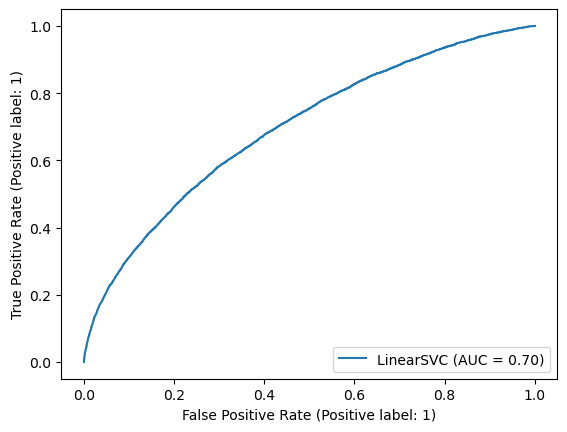

In [46]:
# Create & fit
model = LinearSVC(random_state=42, penalty='l2')
model.fit(train_X, train_Y)

# Evaluate on the test data
test_Y_pred = model.predict(test_X)
print('Prediction accuracy rate = ', str((test_Y == test_Y_pred).mean()))

RocCurveDisplay.from_estimator(model, test_X, test_Y)

## Let's try scaling the data first

Scikit-learn allows us to compose a preprocessing step (and more) followed by an ML model.

Here, the preprocessing step computes the z-scores of the data (zero mean, unit variance), which often improves the performance of ML models.

Prediction accuracy rate =  0.8836568134467472


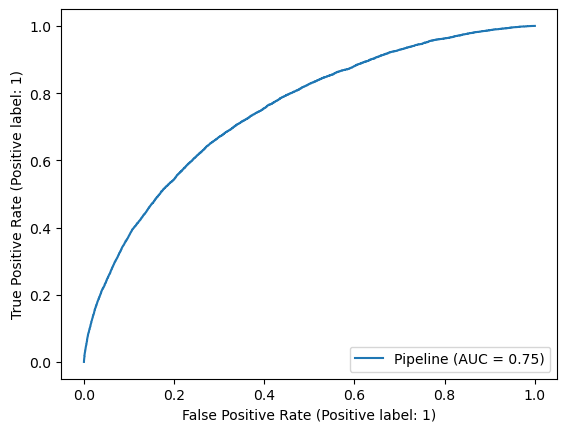

In [47]:
# "model" is now a "pipeline"
model = make_pipeline(
    StandardScaler(),
    LinearSVC(random_state=42, penalty='l2')
)
model.fit(train_X, train_Y)

# Evaluate on the test data
test_Y_pred = model.predict(test_X)
print('Prediction accuracy rate = ', str((test_Y == test_Y_pred).mean()))

RocCurveDisplay.from_estimator(model, test_X, test_Y)

## Cross-validation

Here's a schematic illustration of how cross-validation splits the data to help find a good set of hyperparameters:

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" />

And here's some code to run it easily using scikit-learn.

(Be careful if you are working with timeseries data, or data with a time dimension: you should take that into account, as in this example: https://otexts.com/fpp3/tscv.html)


In [ ]:
# 5-fold cross validation for a RandomForestClassifier
if False:

    # Step 1: run cross-validation on the training data
    # This involves splitting the data 5 times and fitting 4*3=12 models on each split ("fold"), 
    # for a total of 5*12 = 60 fits. This will take some time!
    # Then it will pick the model-hyperparameter combination that performs best on average across the 5 splits, and refit to the entire training data.
    # This will take some time!
    number_of_cross_validation_splits = 5
    possible_hyperparameter_values = {
        'n_estimators': [20, 50, 100, 200]
        , 'max_depth': [5, 7, 9]
    }
    cv_model = GridSearchCV(RandomForestClassifier, possible_hyperparameter_values, cv=number_of_cross_validation_splits)
    cv_model.fit(train_X, train_Y)
    
    # Step 2: print out the optimal parameter values
    print(cv_model.best_params_) 
    # Similarly you can inspect the grid scores using cv_model.cv_results_
    
    # Step 3: Evaluate optimal model on the test data
    test_Y_pred = cv_model.predict(test_X)
    print('Prediction accuracy rate = ', str((test_Y == test_Y_pred).mean()))
    
    RocCurveDisplay.from_estimator(cv_model, test_X, test_Y)


---

# OLS Regression using statsmodel

In [48]:
howell_df = pd.read_csv('Howell1.csv', delimiter=';')

This dataset consists of measurements of the Khosan people:
* Sex
* Age (years)
* Weight (kg)
* Total height (cm)

In [49]:
# Start by looking at adults
howell_adults_df = howell_df[howell_df['age'] >= 18] 

In [50]:
howell_adults_df

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


In [51]:
howell_adults_df.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


<Axes: xlabel='weight', ylabel='height'>

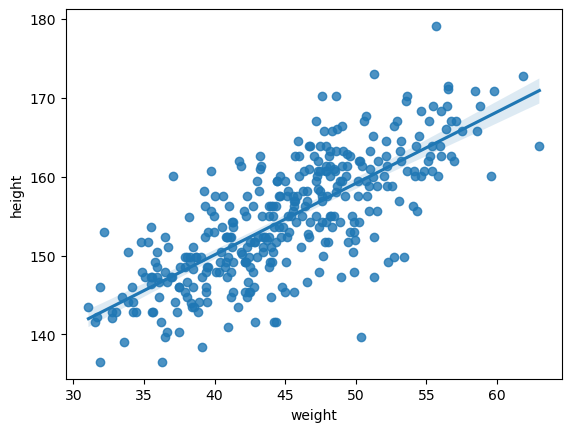

In [52]:
sns.regplot(data=howell_adults_df, x='weight', y='height')

## Running a univariate regression

The goal is to estimate the intercept $\alpha$ and coefficient $\beta$:
$$ \text{Height}_i = \alpha + \beta \times \text{Weight}_i + \varepsilon_i $$ 

In [53]:
model = smf.ols(formula="height ~ weight", data=howell_adults_df)

In [54]:
result = model.fit()

In [55]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Fri, 16 Aug 2024   Prob (F-statistic):           4.68e-66
Time:                        11:04:49   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.8794      1.911     59.589      0.0

## Running a multivariate regression

More than one variable may be associated with height, so we can estimate multiple coefficients $\beta_1, \beta_2, \beta_3$ to understand variable-specific associations (assuming all the other variables do not vary). Any variables not included in this regression are not taken into account.

Note that this does not necessarily tell us anything about causality: does increasing your weight cause your height to increase? Also, note that Male is an indicator/dummy variable that takes the values 0 or 1.

$$ \text{Height}_i = \alpha + \beta_1 \times \text{Weight}_i + \beta_2 \times \text{Age}_i + \beta_3 \times \text{Male}_i + \varepsilon_i $$ 

In [56]:
model = smf.ols(formula="height ~ weight + age + male", data=howell_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1441.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          3.16e-257
Time:                        11:14:42   Log-Likelihood:                -1978.5
No. Observations:                 544   AIC:                             3965.
Df Residuals:                     540   BIC:                             3982.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.9424      1.065     71.327      0.0

## Worried about heteroscedasticity? 

Heteroscedasticity is a major concern in econometrics: `statsmodels` allows you to use different methods to compute your standard errors to deal with this:

In [57]:
rob_result = model.fit().get_robustcov_results(cov_type='HC3')

In [58]:
print(rob_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     812.0
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          1.23e-199
Time:                        11:20:20   Log-Likelihood:                -1978.5
No. Observations:                 544   AIC:                             3965.
Df Residuals:                     540   BIC:                             3982.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.9424      1.496     50.752      0.0

## Worried about outliers?

There aren't any extreme outliers in our data. If there were, and they were distorting the regression results, some fields are fine with excluding them or [winsorizing them](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html) - as long as this is transparently reported in your study, of course. Otherwise, consider using [robust regression](https://www.statsmodels.org/stable/rlm.html) models.

## Beyond adults

<Axes: xlabel='age', ylabel='height'>

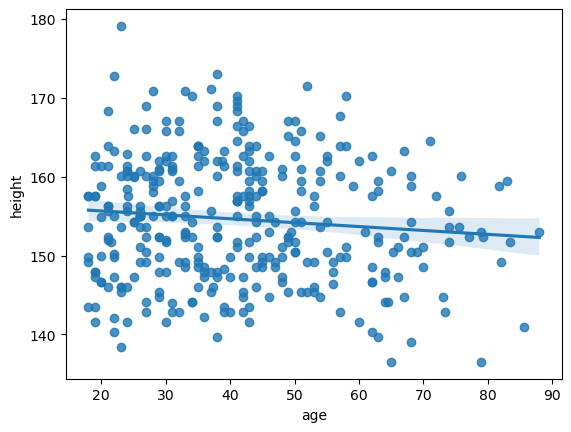

In [59]:
# Sub-sample of adults
sns.regplot(data=howell_adults_df, x='age', y='height')

<Axes: xlabel='age', ylabel='height'>

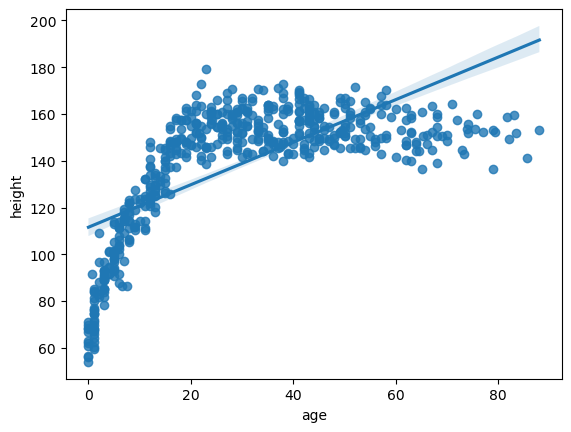

In [60]:
# Entire sample
sns.regplot(data=howell_df, x='age', y='height')

In [61]:
model = smf.ols(formula="height ~ weight + age + male", data=howell_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1441.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          3.16e-257
Time:                        11:22:39   Log-Likelihood:                -1978.5
No. Observations:                 544   AIC:                             3965.
Df Residuals:                     540   BIC:                             3982.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.9424      1.065     71.327      0.0

In [62]:
# Adding a quadratic term:
model = smf.ols(formula="height ~ weight + age + np.power(age, 2) + male", data=howell_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     1237.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          6.46e-270
Time:                        11:23:28   Log-Likelihood:                -1945.2
No. Observations:                 544   AIC:                             3900.
Df Residuals:                     539   BIC:                             3922.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           75.5169      1.004  

## Multicollinearity

There is a warning above about potential numerical problems, such as multicollinearity in the variables. 

Let's check for that in a heuristic way using [Variance Inflation Factors](https://en.wikipedia.org/wiki/Variance_inflation_factor):

In [63]:
variables = model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[7.26917786010102,
 5.428763226489203,
 42.033120844736324,
 28.50829792835161,
 1.126932559483217]

It seems that the third variable (age) is problematic, so let's run without it:

In [64]:
# Adding a quadratic term:
model = smf.ols(formula="height ~ weight + np.power(age, 2) + male", data=howell_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1406.
Date:                Fri, 16 Aug 2024   Prob (F-statistic):          1.22e-254
Time:                        11:26:23   Log-Likelihood:                -1984.5
No. Observations:                 544   AIC:                             3977.
Df Residuals:                     540   BIC:                             3994.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           75.8038      1.077  

In [65]:
howell_df[['weight', 'age', 'male']].corr()

,weight,age,male
weight,1.000000,0.678335,0.155443
age,0.678335,1.000000,0.005887
male,0.155443,0.005887,1.000000


In [66]:
variables = model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[7.262080619173248, 1.3120513488623493, 1.2804008517343353, 1.030553618695109]

## Producing $\LaTeX$ for your research paper

In [67]:
print(result.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      height      & \textbf{  R-squared:         } &     0.887   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.886   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     1406.   \\
\textbf{Date:}             & Fri, 16 Aug 2024 & \textbf{  Prob (F-statistic):} & 1.22e-254   \\
\textbf{Time:}             &     11:27:13     & \textbf{  Log-Likelihood:    } &   -1984.5   \\
\textbf{No. Observations:} &         544      & \textbf{  AIC:               } &     3977.   \\
\textbf{Df Residuals:}     &         540      & \textbf{  BIC:               } &     3994.   \\
\textbf{Df Model:}         &           3      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                          & \textbf{coe

---

# Quiz: Revisiting Starbucks 

* Suppose you intend to examine whether sodium contributes to an increase in calories. 
* Also suppose you know sugar and trans fat have been strong factors for high calories. 
* Taken together, you want to see the association between sodium and calories while controlling for sugar and trans fat. 
* (1) Draw three plots, each of which represents the relationship between each of the three variables above and calories. (Use `regplot()` in seaborn)
* (2) Using the `statsmodel` package, print the result of OLS regression whose formula looks like this: `Calories ~ Sodium + Sugars + TransFat`
* (3) Once you control for sugars and tran sfar, is there a significant association between sodium and calories?

In [68]:
sb_df = pd.read_csv('menu_starbucks.csv')

In [69]:
# I'll help you with some cleaning of the column names:
sb_df.columns = sb_df.columns.str.replace(r'\([^)]*\)', "").str.rstrip(" ").str.lstrip(" ")

In [70]:
sb_df.columns

Index(['Beverage_category', 'Beverage', 'Beverage_prep', 'Calories',
       'Total Fat (g)', 'Trans Fat (g)', 'Saturated Fat (g)', 'Sodium (mg)',
       'Total Carbohydrates (g)', 'Cholesterol (mg)', 'Dietary Fibre (g)',
       'Sugars (g)', 'Protein (g)', 'Vitamin A (% DV)', 'Vitamin C (% DV)',
       'Calcium (% DV)', 'Iron (% DV)', 'Caffeine (mg)'],
      dtype='object')

In [ ]:
# TODO: part (1)

In [ ]:
# TODO: part (2)

---

# Arrays: a case study with OLS regression

Let's say we want to regress a variable $y$ against three variables $x_1$, $x_2$, $x_3$, and we have $i=1,..,N$ samples. Then the objective is to estimate three quantities: $\beta_1$, $\beta_2$, $\beta_3$ that work for all the $N$ values of $y$ and $x_1$, $x_2$, $x_3$.

$$y_i = \beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i} \quad\text{for}\quad i=1,..,N$$

Really, we have $N$ rows for which this must hold:
$$y_1 = \beta_1 x_{1,1} + \beta_2 x_{2,1} + \beta_3 x_{3,1}$$
$$\ldots$$
$$y_i = \beta_1 x_{1,i} + \beta_2 x_{2,i} + \beta_3 x_{3,i}$$
$$\ldots$$
$$y_N = \beta_1 x_{1,N} + \beta_2 x_{2,N} + \beta_3 x_{3,N}$$

The system of equations above can be represented using matrix multiplication:

$$ \begin{bmatrix} 
        y_1 \\ \vdots \\ y_i \\ \vdots \\ y_N 
    \end{bmatrix}  = \begin{bmatrix} 
    x_{1,1} & x_{2,1} & x_{3,1} \\
    & \vdots & \\
    x_{1,i} & x_{2,i} & x_{3,i} \\
    & \vdots & \\
    x_{1,N} & x_{2,N} & x_{3,N}
    \end{bmatrix} 
    \begin{bmatrix} 
        \beta_1 \\ \beta_2 \\ \beta_3 
    \end{bmatrix} $$

We'll write these matrices as Y, X, B:
$$ Y = XB $$



Let's solve for $B$. Pre-multiply both sides with $X^T$, the transpose of $X$:

$$ X^T Y = X^T XB $$

Pre-multiply both sides with $(X^TX)^{-1}$, the inverse of the product $X^T X$:

$$ (X^TX)^{-1} X^T Y = (X^TX)^{-1} X^T XB $$

Since $(X^TX)^{-1}$ cancels out $X^T X$, we have our exact solution:

$$ B = (X^TX)^{-1} X^T Y $$

So let's implement multivariate regression ourselves! We just need to know three operations:
* matrix multiplication
* matrix transposition
* matrix inversion

Arrays and the `numpy` package give us what we need.

## Creating matrices from data frames

In [71]:
X = howell_adults_df[['weight', 'age', 'male']].values

In [72]:
X.shape

(352, 3)

In [73]:
X

array([[47.8256065, 63.       ,  1.       ],
       [36.4858065, 63.       ,  0.       ],
       [31.864838 , 65.       ,  0.       ],
       ...,
       [52.16308  , 31.       ,  1.       ],
       [54.0624965, 21.       ,  0.       ],
       [52.5316235, 68.       ,  1.       ]])

In [74]:
Y = howell_adults_df[['height']].values

In [75]:
Y.shape

(352, 1)

In [76]:
Y

array([[151.765 ],
       [139.7   ],
       [136.525 ],
       [156.845 ],
       [145.415 ],
       [163.83  ],
       [149.225 ],
       [168.91  ],
       [147.955 ],
       [165.1   ],
       [154.305 ],
       [151.13  ],
       [144.78  ],
       [149.9   ],
       [150.495 ],
       [163.195 ],
       [157.48  ],
       [143.9418],
       [161.29  ],
       [156.21  ],
       [146.4   ],
       [148.59  ],
       [147.32  ],
       [147.955 ],
       [161.925 ],
       [146.05  ],
       [146.05  ],
       [152.7048],
       [142.875 ],
       [142.875 ],
       [147.955 ],
       [160.655 ],
       [151.765 ],
       [162.8648],
       [171.45  ],
       [147.32  ],
       [147.955 ],
       [154.305 ],
       [143.51  ],
       [146.7   ],
       [157.48  ],
       [165.735 ],
       [152.4   ],
       [141.605 ],
       [158.8   ],
       [155.575 ],
       [164.465 ],
       [151.765 ],
       [161.29  ],
       [154.305 ],
       [145.415 ],
       [145.415 ],
       [152.

## Matrix operations

Here's how to calculate $X^T$, the transpose of X:

In [77]:
X.T

array([[47.8256065, 36.4858065, 31.864838 , ..., 52.16308  , 54.0624965,
        52.5316235],
       [63.       , 63.       , 65.       , ..., 31.       , 21.       ,
        68.       ],
       [ 1.       ,  0.       ,  0.       , ...,  1.       ,  0.       ,
         1.       ]])

In [78]:
X.T.shape

(3, 352)

The function `matmul` from package `numpy` (abbreviated `np`) multiplies two matrices. 

So to calculate $X^T X$ we would write:

In [79]:
np.matmul(X.T, X)

array([[7.27131480e+05, 6.45238909e+05, 8.01739735e+03],
       [6.45238909e+05, 6.85211563e+05, 6.86755000e+03],
       [8.01739735e+03, 6.86755000e+03, 1.65000000e+02]])


**Quiz** Calculate $X^T Y$

In [80]:
np.matmul(X.T, Y)

array([[2461543.35685838],
       [2234262.7437    ],
       [  26459.1486    ]])

The function `linalg.inv` (from the same packages) takes the inverse of a matrix.

So to calculate $(X^T X)^{-1}$ we would write:

In [81]:
np.linalg.inv(np.matmul(X.T, X))

array([[ 1.05779553e-05, -8.25163087e-06, -1.70540502e-04],
       [-8.25163087e-06,  8.94083659e-06,  2.88179461e-05],
       [-1.70540502e-04,  2.88179461e-05,  1.31477714e-02]])

We're almost there! 

**Quiz** Calculate:

$B = (X^T X)^{-1} X^T Y$

In [82]:
np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

array([[ 3.08942759],
       [ 0.42692926],
       [-7.52713918]])

You should get coefficient values like the ones below:

In [83]:
model = smf.ols(formula="height ~ 0 + weight + age + male", data=howell_adults_df)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 height   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.306e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        11:35:39   Log-Likelihood:                         -1441.8
No. Observations:                 352   AIC:                                      2890.
Df Residuals:                     349   BIC:                                      2901.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Quiz for later**

Look up (from a textbook) how to add an intercept for the OLS solution, and then modify the above to achieve it.

*Hint:* the formula is exactly the same, you need to make a change to the array `X`.

In [ ]:
# TODO: quiz for later

---

# Optimization: a case study with OLS regression

OLS = Ordinary Least Squares.

"Least squares" because the optimal $\beta$ values are those which minimize the sum of squared errors.

Let's say you pick these values of beta:

In [84]:
beta_1 = 2
beta_2 = 1
beta_3 = -5

Then you would predict the following values of $y_i$ for each value of $x_1$, $x_2$, $x_3$:

In [85]:
predictions = beta_1 * howell_adults_df['weight'] + beta_2 * howell_adults_df['age'] + beta_3 * howell_adults_df['male']
predictions

0      153.651213
1      135.971613
2      128.729676
3      142.083829
4      133.553744
          ...    
534    121.063641
537     99.492392
540    130.326160
541    129.124993
543    168.063247
Length: 352, dtype: float64

The difference between the true values and the predictions are the errors/residuals:



In [86]:
errors = howell_adults_df['height'] - predictions
errors

0      -1.886213
1       3.728387
2       7.795324
3      14.761171
4      11.861256
         ...    
534    41.496359
537    43.382608
540    32.233840
541    27.085007
543    -9.313247
Length: 352, dtype: float64

The squared errors are:

In [87]:
errors**2

0         3.557799
1        13.900870
2        60.767076
3       217.892169
4       140.689394
          ...     
534    1721.947810
537    1882.050677
540    1039.020441
541     733.597604
543      86.736570
Length: 352, dtype: float64

So the sum of squared errors is:

In [88]:
sum(errors**2)

333619.36990389536

The optimal $\beta$s would minimize this sum of squared errors. This is an optimization problem.

In [89]:
def sse(betas_list):
    (beta_1, beta_2, beta_3) = betas_list
    predictions = beta_1 * howell_adults_df['weight'] + beta_2 * howell_adults_df['age'] + beta_3 * howell_adults_df['male']
    errors = howell_adults_df['height'] - predictions
    sse = sum(errors**2)
    return sse

In [90]:
sse([2, 1, -5])

333619.36990389536

In [91]:
sse([1, 2, 3])

595972.8969114538

In [92]:
scipy.optimize.minimize(sse, [0,0,0])

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 74461.73359698104
        x: [ 3.089e+00  4.269e-01 -7.527e+00]
      nit: 10
      jac: [ 0.000e+00 -9.766e-04  0.000e+00]
 hess_inv: [[ 3.409e-06 -2.640e-06 -4.097e-05]
            [-2.640e-06  2.796e-06  2.506e-05]
            [-4.097e-05  2.506e-05  1.377e-03]]
     nfev: 272
     njev: 65

We should get coefficient values like the ones below:

In [93]:
model = smf.ols(formula="height ~ 0 + weight + age + male", data=howell_adults_df)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 height   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          1.306e+04
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        11:42:51   Log-Likelihood:                         -1441.8
No. Observations:                 352   AIC:                                      2890.
Df Residuals:                     349   BIC:                                      2901.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Quiz**. 

Change the function `sse` to add an intercept $\beta_0$. 

And then run `scipy.optimize.minimize(sse, [0,0,0,0])`

In [ ]:
# TODO: quiz